In [1]:
import numpy as np
import os
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


# load ndarray

In [2]:
def load_image(path):
    image_list=[]
    for filename in os.listdir(path):
        image=load_img(os.path.join(path,filename))
        image=img_to_array(image) #to ndarray
        image_list.append(image)
    return np.asarray(image_list,'float') 

In [3]:
trainA=load_image('horse2zebra//trainA')
testA=load_image('horse2zebra//testA')
trainB=load_image('horse2zebra//trainB')
testB=load_image('horse2zebra//testB')
print(trainA.shape,trainB.shape)
print(testA.shape,testB.shape)

(1067, 256, 256, 3) (1334, 256, 256, 3)
(120, 256, 256, 3) (140, 256, 256, 3)


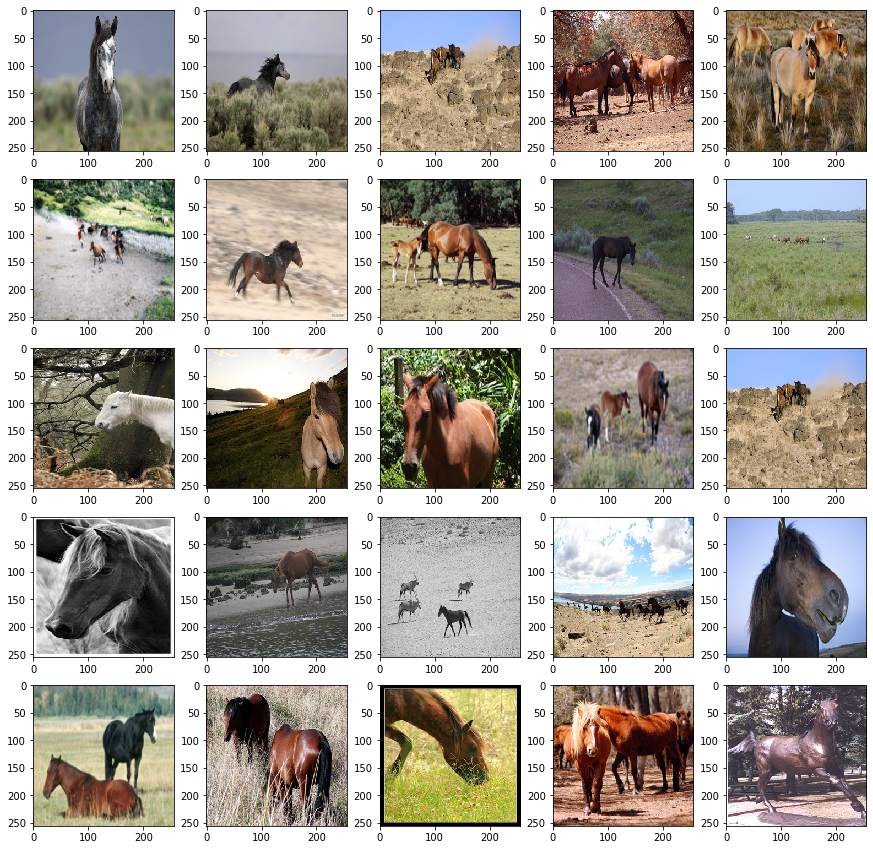

In [4]:
randi=np.random.randint(0,trainA.shape[0],25)
randA=trainA[randi]
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(randA[i].astype(int))

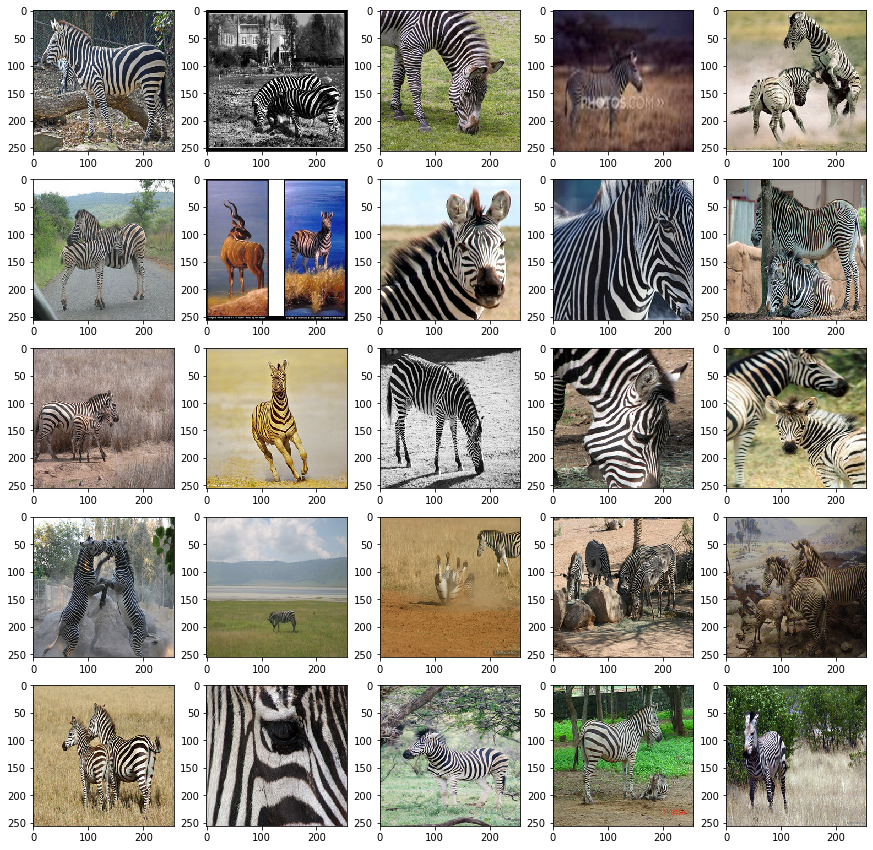

In [5]:
randi=np.random.randint(0,trainB.shape[0],25)
randB=trainB[randi]
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(randB[i].astype(int))

# Discriminator NN  
![cycleGAN](https://1.bp.blogspot.com/-cj53ochEvkY/XVPRc4F9A0I/AAAAAAAAEbQ/ERiS_nhQpPEDZOOk8SrxmQ6E2CdZFXMTACLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  
implement the PatchGAN discriminator  

GAN一般情況下的網絡結構，在一些人的實驗中已經表明對於要求高分辨率、高細節保持的圖像領域中並不適合，有些人根據這一情況設計了PatchGAN的思路。這種GAN的差別主要是在於Discriminator上，一般的GAN是只需要輸出一個true or fasle 的矢量，這是代表對整張圖像的評價；但是PatchGAN輸出的是一個N x N的矩陣，這個N x N的矩陣的每一個元素，比如a(i,j) 只有True or False 這兩個選擇（label 是N x N的矩陣，每一個元素是True 或者False），這樣的結果往往是通過卷積層來達到的，因為逐次疊加的捲積層最終輸出的這個N x N 的矩陣，其中的每一個元素，實際上代表著原圖中的一個比較大的感受野，也就是說對應著原圖中的一個Patch，因此具有這樣結構以及這樣輸出的GAN被稱之為Patch GAN。 

Native keras doesn't go well with tf.keras. 若用tf，則InstanceNormalization會無法執行。  

__pip install git+https://www.github.com/keras-team/keras-contrib.git 安裝instancenormalization__  

In [6]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [7]:
def discriminator(image_shape):
    init=keras.initializers.RandomNormal(stddev=0.02) #normal distribution
    x_input=keras.layers.Input(shape=image_shape)
    #to(128*128*64)
    x=keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x_input)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(64*64*128)
    x=keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(32*32*256)
    x=keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(16*16*512)
    x=keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    x=keras.layers.Conv2D(512,(4,4),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(16*16*1),N*N為16*16*1
    x=keras.layers.Conv2D(1,(4,4),padding='same',kernel_initializer=init)(x) 
    
    model=keras.Model(inputs=x_input,outputs=x)
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss_weights=[0.5])
    return model

In [8]:
model=discriminator(trainA[0].shape)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       5245

# Generator NN  
![cycleGAN](https://1.bp.blogspot.com/-cj53ochEvkY/XVPRc4F9A0I/AAAAAAAAEbQ/ERiS_nhQpPEDZOOk8SrxmQ6E2CdZFXMTACLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  

### Residual NN

In [9]:
def residual_block(filters,input_layer):
    init=keras.initializers.RandomNormal(stddev=0.02) #normal distribution
    #1st
    x=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #2nd
    x=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    x=InstanceNormalization(axis=-1)(x)
    
    x=keras.layers.Concatenate()([x,input_layer])
    return x

![generator](https://hardikbansal.github.io/CycleGANBlog/images/Generator.jpg)  
First downsampling then upsmapling,interpreting the encoding with a number of ResNet layers  

In [10]:
def generator(image_shape,residual_num=3):
    init=keras.initializers.RandomNormal(stddev=0.02)
    x_input=keras.layers.Input(shape=image_shape)
    
    #downsampling
    #to(256*256*64)
    x=keras.layers.Conv2D(64,(7,7),padding='same',kernel_initializer=init)(x_input)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(128*128*128)
    x=keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(64*64*256)
    x=keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    
    for i in range(residual_num):
        x=residual_block(256,x)
        
    #upsampling
    #to(128*128*128)
    x=keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(256*256*64)
    x=keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(256*256*3)
    x=keras.layers.Conv2D(3,(7,7),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('tanh')(x)
    
    model=keras.Model(inputs=x_input,outputs=x)
    
    return model

In [11]:
model=generator(trainA[0].shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_5 (Insta (None, 256, 256, 64) 128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           instance_normalization_5[0][0]   
____________________________________________________________________________________________

# composite NN (目的是為了要訓練g_model)
假設我們要訓練一個A->B的generator  
updated via the weighted sum of four loss function:  
* __Adversarial Loss__: Domain-A -> Generator-B -> Domain-B -> Discriminator-B -> \[real/fake\]
* __Identity Loss__: Domain-B -> Generator-B -> Domain-B
* __Forward Cycle Loss__: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A
* __Backward Cycle Loss__: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B

input is Domain-A & Domain-B  

In [12]:
#Domain A->Domain B ; g_modelB:image to Domain B
def composite(g_modelAtoB,g_modelBtoA,d_model,input_shape): 
    g_modelAtoB.trainable=True 
    g_modelBtoA.trainable=False
    d_model.trainable=False
    
    A_input=keras.layers.Input(shape=input_shape)
    B_input=keras.layers.Input(shape=input_shape)
    #adversarial loss
    adversary_output=g_modelAtoB(A_input)
    adversary_output=d_model(adversary_output)
    #identity loss
    identity_output=g_modelAtoB(B_input)
    #forward cycle loss
    forward_output=g_modelAtoB(A_input)
    forward_output=g_modelBtoA(forward_output)
    #backward cycle loss
    backward_output=g_modelBtoA(B_input)
    backward_output=g_modelAtoB(backward_output)
    
    model=keras.Model(inputs=[A_input,B_input],outputs=[adversary_output,identity_output,forward_output,backward_output])
    model.compile(loss=['mse','mae','mae','mae'],optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss_weights=[1,5,10,10])
    return model

# Image_Generator(for Discriminator)

In [13]:
def real_image_generator(dataset,num,patch_shape):
    randi=np.random.randint(0,dataset.shape[0],num)
    x=dataset[randi]
    y=np.ones((num,)+patch_shape)
    return x,y

In [14]:
#圖片生圖片
def fake_image_generator(g_model,images,patch_shape): 
    x=g_model.predict(images)
    y=np.zeros((images.shape[0],)+patch_shape)
    return x,y

# Training

In [15]:
#會使用舊的image
def update_fake_image(pool,images,pool_size=50):
    select=[]
    for image in images:
        if len(pool)<pool_size:
            pool.append(image)
            select.append(image)
        elif np.random.random()<0.5:
            select.append(image)
        else: #use old
            randi=np.random.randint(0,pool_size)
            select.append(pool[randi])
            pool[randi]=image
    return np.asarray(select,'float')

要train 4個NN:  
![cycleGAN](https://i.imgur.com/OH7Tvpy.png)  

In [16]:
def fit(g_modelAtoB,g_modelBtoA,d_modelA,d_modelB,c_modelAtoB,c_modelBtoA,A,B,epochs=100,batch_size=1):
    batchs=A.shape[0]//batch_size
    poolA,poolB=[],[]
    patch_shape=d_modelA.output_shape[1:]
    for epoch in range(1,epochs+1):
        for batch in range(1,batchs+1):
            #domain images
            realA_x,realA_y=real_image_generator(A,batch_size,patch_shape)
            realB_x,realB_y=real_image_generator(B,batch_size,patch_shape)
            fakeA_x,fakeA_y=fake_image_generator(g_modelBtoA,realB_x,patch_shape)
            fakeB_x,fakeB_y=fake_image_generator(g_modelAtoB,realA_x,patch_shape)
            fakeA_x=update_fake_image(poolA,fakeA_x)
            fakeB_x=update_fake_image(poolB,fakeB_x)
            #update generator_B->A
            loss_g_BA,_,_,_,_=c_modelBtoA.train_on_batch(x=[realB_x,realA_x],y=[realA_y,realA_x,realB_x,realA_x])
            #update discriminator_A
            loss_d1_A=d_modelA.train_on_batch(x=realA_x,y=realA_y)
            loss_d2_A=d_modelA.train_on_batch(x=fakeA_x,y=fakeA_y)
            #update generator_A->B
            loss_g_AB,_,_,_,_=c_modelAtoB.train_on_batch(x=[realA_x,realB_x],y=[realB_y,realB_x,realA_x,realB_x])
            #update discriminator_B
            loss_d1_B=d_modelB.train_on_batch(x=realB_x,y=realB_y)
            loss_d2_B=d_modelB.train_on_batch(x=fakeB_x,y=fakeB_y)
            if batch%100==0:
                print('epoch{} {}/{} dA[{:.2f} {:.2f}] dB[{:.2f} {:.2f}] gA[{:.2f}] gB[{:.2f}]'.format(epoch,batch,batchs,loss_d1_A,loss_d2_A,loss_d1_B,loss_d2_B,loss_g_BA,loss_g_AB))
        if epoch%5==0:
            summarize(epoch,g_modelAtoB,g_modelBtoA,A,B)

In [17]:
#save img,save model
def summarize(epoch,g_modelAtoB,g_modelBtoA,A,B):
    in_A,_=real_image_generator(A,5,(0,))
    out_B,_=fake_image_generator(g_modelAtoB,in_A,(0,))
    in_B,_=real_image_generator(B,5,(0,))
    out_A,_=fake_image_generator(g_modelBtoA,in_B,(0,))
    in_A=(in_A+1)/2
    out_B=(out_B+1)/2
    in_B=(in_B+1)/2
    out_A=(out_A+1)/2
    
    plt.figure(figsize=(15,12))
    #Domain A-> Domain B
    for i in range(5):
        plt.subplot(4,5,i+1)
        plt.imshow(in_A[i])
        plt.axis('off')
        plt.title('real A')
        plt.subplot(4,5,i+1+5)
        plt.imshow(out_B[i])
        plt.axis('off')
        plt.title('fake B')
    #B->A
    for i in range(5):
        plt.subplot(4,5,10+i+1)
        plt.imshow(in_B[i])
        plt.axis('off')
        plt.title('real B')
        plt.subplot(4,5,10+i+1+5)
        plt.imshow(out_A[i])
        plt.axis('off')
        plt.title('fake A')
    plt.savefig('cycleGAN horse-zebra//epoch{}.png'.format(epoch))
    plt.close()
    #save model
    g_modelAtoB.save('cycleGAN horse-zebra//generator AtoB epoch{}.h5'.format(epoch))
    g_modelBtoA.save('cycleGAN horse-zebra//generator BtoA epoch{}.h5'.format(epoch))

# Start GAN

### load A&B from [0,255] to [-1,1]

In [18]:
trainA=(trainA-127.5)/127.5
trainB=(trainB-127.5)/127.5

### train

In [19]:
g_modelAtoB=generator(trainA[0].shape)
g_modelBtoA=generator(trainB[0].shape)
d_modelA=discriminator(trainA[0].shape)
d_modelB=discriminator(trainB[0].shape)
c_modelAtoB=composite(g_modelAtoB,g_modelBtoA,d_modelB,trainA[0].shape)
c_modelBtoA=composite(g_modelBtoA,g_modelAtoB,d_modelA,trainB[0].shape)

fit(g_modelAtoB,g_modelBtoA,d_modelA,d_modelB,c_modelAtoB,c_modelBtoA,trainA,trainB,epochs=100)

/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/ke

epoch1 100/1067 dA[0.15 0.15] dB[0.25 0.20] gA[5.58] gB[5.93]
epoch1 200/1067 dA[0.34 0.17] dB[0.17 0.21] gA[6.95] gB[5.96]
epoch1 300/1067 dA[0.09 0.28] dB[0.10 0.20] gA[5.87] gB[6.05]
epoch1 400/1067 dA[0.33 0.13] dB[0.14 0.10] gA[5.16] gB[5.02]
epoch1 500/1067 dA[0.18 0.10] dB[0.08 0.14] gA[7.06] gB[7.05]
epoch1 600/1067 dA[0.08 0.14] dB[0.22 0.03] gA[5.63] gB[6.59]
epoch1 700/1067 dA[0.01 0.06] dB[0.04 0.06] gA[6.57] gB[6.12]
epoch1 800/1067 dA[0.16 0.22] dB[0.07 0.19] gA[5.21] gB[4.74]
epoch1 900/1067 dA[0.43 0.07] dB[0.09 0.01] gA[7.98] gB[8.07]
epoch1 1000/1067 dA[0.11 0.26] dB[0.42 0.04] gA[3.93] gB[4.43]
epoch2 100/1067 dA[0.02 0.09] dB[0.21 0.14] gA[4.25] gB[4.48]
epoch2 200/1067 dA[0.18 0.23] dB[0.05 0.21] gA[5.97] gB[5.66]
epoch2 300/1067 dA[0.27 0.17] dB[0.03 0.06] gA[4.26] gB[4.09]
epoch2 400/1067 dA[0.06 0.19] dB[0.20 0.11] gA[3.87] gB[3.68]
epoch2 500/1067 dA[0.04 0.20] dB[0.11 0.02] gA[4.71] gB[5.45]
epoch2 600/1067 dA[0.06 0.07] dB[0.05 0.28] gA[8.29] gB[7.13]
epoch2 

epoch14 300/1067 dA[0.00 0.01] dB[0.06 0.05] gA[4.45] gB[4.22]
epoch14 400/1067 dA[0.01 0.13] dB[0.01 0.01] gA[4.52] gB[4.02]
epoch14 500/1067 dA[0.02 0.01] dB[0.01 0.06] gA[4.29] gB[3.52]
epoch14 600/1067 dA[0.02 0.01] dB[0.01 0.04] gA[4.14] gB[3.26]
epoch14 700/1067 dA[0.00 0.01] dB[0.02 0.01] gA[5.36] gB[4.16]
epoch14 800/1067 dA[0.30 0.04] dB[0.01 0.02] gA[3.74] gB[3.04]
epoch14 900/1067 dA[0.00 0.01] dB[0.14 0.06] gA[4.07] gB[3.11]
epoch14 1000/1067 dA[0.01 0.03] dB[0.02 0.01] gA[3.89] gB[3.59]
epoch15 100/1067 dA[0.02 0.09] dB[0.01 0.01] gA[4.99] gB[4.69]
epoch15 200/1067 dA[0.01 0.01] dB[0.00 0.04] gA[4.21] gB[3.96]
epoch15 300/1067 dA[0.03 0.01] dB[0.00 0.01] gA[3.94] gB[3.39]
epoch15 400/1067 dA[0.00 0.10] dB[0.09 0.02] gA[3.23] gB[4.41]
epoch15 500/1067 dA[0.00 0.01] dB[0.15 0.11] gA[4.72] gB[3.80]
epoch15 600/1067 dA[0.03 0.01] dB[0.00 0.02] gA[3.50] gB[3.17]
epoch15 700/1067 dA[0.01 0.03] dB[0.00 0.02] gA[3.85] gB[3.68]
epoch15 800/1067 dA[0.02 0.03] dB[0.01 0.01] gA[5.77] 

epoch27 300/1067 dA[0.02 0.02] dB[0.00 0.12] gA[3.99] gB[3.50]
epoch27 400/1067 dA[0.17 0.02] dB[0.01 0.01] gA[4.62] gB[4.15]
epoch27 500/1067 dA[0.02 0.01] dB[0.15 0.01] gA[4.48] gB[4.00]
epoch27 600/1067 dA[0.00 0.01] dB[0.01 0.01] gA[4.44] gB[3.75]
epoch27 700/1067 dA[0.26 0.01] dB[0.02 0.01] gA[3.26] gB[2.53]
epoch27 800/1067 dA[0.01 0.02] dB[0.00 0.01] gA[3.33] gB[3.82]
epoch27 900/1067 dA[0.01 0.01] dB[0.01 0.00] gA[4.00] gB[4.16]
epoch27 1000/1067 dA[0.21 0.00] dB[0.01 0.07] gA[3.82] gB[2.83]
epoch28 100/1067 dA[0.01 0.01] dB[0.01 0.01] gA[3.22] gB[3.29]
epoch28 200/1067 dA[0.01 0.00] dB[0.31 0.01] gA[2.80] gB[3.15]
epoch28 300/1067 dA[0.01 0.01] dB[0.00 0.01] gA[3.81] gB[4.64]
epoch28 400/1067 dA[0.05 0.01] dB[0.01 0.00] gA[4.33] gB[4.26]
epoch28 500/1067 dA[0.01 0.03] dB[0.05 0.16] gA[3.00] gB[2.77]
epoch28 600/1067 dA[0.01 0.01] dB[0.06 0.02] gA[4.25] gB[3.57]
epoch28 700/1067 dA[0.01 0.01] dB[0.01 0.00] gA[4.82] gB[4.60]
epoch28 800/1067 dA[0.01 0.00] dB[0.00 0.01] gA[4.26] 

epoch40 300/1067 dA[0.00 0.00] dB[0.00 0.00] gA[4.46] gB[4.18]
epoch40 400/1067 dA[0.04 0.01] dB[0.00 0.02] gA[4.07] gB[3.70]
epoch40 500/1067 dA[0.01 0.01] dB[0.00 0.00] gA[4.06] gB[4.12]
epoch40 600/1067 dA[0.00 0.02] dB[0.10 0.12] gA[3.08] gB[1.79]
epoch40 700/1067 dA[0.08 0.01] dB[0.02 0.00] gA[3.10] gB[3.32]
epoch40 800/1067 dA[0.00 0.01] dB[0.04 0.01] gA[4.18] gB[2.99]
epoch40 900/1067 dA[0.39 0.01] dB[0.00 0.00] gA[3.00] gB[3.38]
epoch40 1000/1067 dA[0.00 0.01] dB[0.00 0.00] gA[3.33] gB[3.22]
epoch41 100/1067 dA[0.00 0.00] dB[0.00 0.08] gA[4.15] gB[3.24]
epoch41 200/1067 dA[0.01 0.01] dB[0.00 0.01] gA[4.43] gB[3.85]
epoch41 300/1067 dA[0.00 0.00] dB[0.00 0.00] gA[4.31] gB[4.75]
epoch41 400/1067 dA[0.01 0.01] dB[0.03 0.00] gA[5.00] gB[4.07]
epoch41 500/1067 dA[0.00 0.00] dB[0.00 0.01] gA[3.80] gB[3.21]
epoch41 600/1067 dA[0.04 0.02] dB[0.00 0.00] gA[3.45] gB[3.48]
epoch41 700/1067 dA[0.00 0.00] dB[0.01 0.00] gA[3.16] gB[3.32]
epoch41 800/1067 dA[0.00 0.02] dB[0.00 0.01] gA[4.12] 

epoch53 300/1067 dA[0.00 0.01] dB[0.00 0.00] gA[3.94] gB[3.56]
epoch53 400/1067 dA[0.01 0.00] dB[0.00 0.00] gA[4.09] gB[3.46]
epoch53 500/1067 dA[0.01 0.01] dB[0.00 0.00] gA[3.23] gB[3.36]
epoch53 600/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.91] gB[2.44]
epoch53 700/1067 dA[0.00 0.00] dB[0.00 0.01] gA[4.17] gB[3.35]
epoch53 800/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.72] gB[2.42]
epoch53 900/1067 dA[0.01 0.01] dB[0.00 0.00] gA[4.26] gB[3.18]
epoch53 1000/1067 dA[0.05 0.00] dB[0.01 0.13] gA[3.18] gB[2.24]
epoch54 100/1067 dA[0.00 0.01] dB[0.00 0.01] gA[3.24] gB[2.65]
epoch54 200/1067 dA[0.02 0.00] dB[0.00 0.00] gA[3.17] gB[2.87]
epoch54 300/1067 dA[0.00 0.00] dB[0.00 0.02] gA[3.35] gB[2.83]
epoch54 400/1067 dA[0.01 0.00] dB[0.00 0.01] gA[3.24] gB[3.14]
epoch54 500/1067 dA[0.00 0.03] dB[0.16 0.00] gA[2.38] gB[3.05]
epoch54 600/1067 dA[0.00 0.01] dB[0.14 0.16] gA[2.74] gB[2.95]
epoch54 700/1067 dA[0.01 0.01] dB[0.02 0.03] gA[3.05] gB[2.87]
epoch54 800/1067 dA[0.00 0.02] dB[0.00 0.01] gA[2.59] 

epoch66 300/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.08] gB[2.63]
epoch66 400/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.29] gB[2.91]
epoch66 500/1067 dA[0.01 0.01] dB[0.00 0.01] gA[3.27] gB[2.81]
epoch66 600/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[3.19]
epoch66 700/1067 dA[0.00 0.00] dB[0.00 0.02] gA[3.24] gB[2.75]
epoch66 800/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.55] gB[3.06]
epoch66 900/1067 dA[0.00 0.01] dB[0.07 0.00] gA[2.58] gB[2.70]
epoch66 1000/1067 dA[0.06 0.01] dB[0.00 0.00] gA[3.24] gB[3.22]
epoch67 100/1067 dA[0.00 0.00] dB[0.00 0.00] gA[5.39] gB[4.48]
epoch67 200/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.23] gB[2.99]
epoch67 300/1067 dA[0.01 0.00] dB[0.00 0.00] gA[2.86] gB[2.62]
epoch67 400/1067 dA[0.00 0.01] dB[0.00 0.00] gA[3.12] gB[3.31]
epoch67 500/1067 dA[0.00 0.13] dB[0.00 0.00] gA[2.07] gB[2.81]
epoch67 600/1067 dA[0.00 0.02] dB[0.00 0.00] gA[3.24] gB[3.15]
epoch67 700/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.02] gB[2.77]
epoch67 800/1067 dA[0.00 0.01] dB[0.00 0.00] gA[1.77] 

epoch79 300/1067 dA[0.00 0.00] dB[0.00 0.00] gA[4.88] gB[3.59]
epoch79 400/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.38] gB[2.31]
epoch79 500/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.06] gB[2.70]
epoch79 600/1067 dA[0.00 0.06] dB[0.00 0.00] gA[4.08] gB[3.65]
epoch79 700/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.05] gB[3.03]
epoch79 800/1067 dA[0.01 0.00] dB[0.00 0.00] gA[2.76] gB[2.60]
epoch79 900/1067 dA[0.00 0.01] dB[0.00 0.00] gA[1.82] gB[2.56]
epoch79 1000/1067 dA[0.00 0.02] dB[0.00 0.00] gA[3.07] gB[3.17]
epoch80 100/1067 dA[0.00 0.04] dB[0.00 0.00] gA[2.65] gB[2.79]
epoch80 200/1067 dA[0.00 0.01] dB[0.00 0.00] gA[3.00] gB[2.85]
epoch80 300/1067 dA[0.01 0.00] dB[0.00 0.00] gA[3.07] gB[2.73]
epoch80 400/1067 dA[0.00 0.00] dB[0.01 0.01] gA[3.18] gB[2.83]
epoch80 500/1067 dA[0.00 0.00] dB[0.07 0.00] gA[2.90] gB[2.42]
epoch80 600/1067 dA[0.00 0.01] dB[0.00 0.00] gA[2.76] gB[2.48]
epoch80 700/1067 dA[0.02 0.00] dB[0.00 0.00] gA[2.88] gB[2.72]
epoch80 800/1067 dA[0.00 0.01] dB[0.00 0.00] gA[2.75] 

epoch92 300/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.26] gB[3.16]
epoch92 400/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.85] gB[2.69]
epoch92 500/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.67] gB[2.64]
epoch92 600/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.31] gB[2.03]
epoch92 700/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.17] gB[2.53]
epoch92 800/1067 dA[0.00 0.00] dB[0.01 0.00] gA[2.13] gB[2.53]
epoch92 900/1067 dA[0.00 0.00] dB[0.01 0.00] gA[2.88] gB[2.47]
epoch92 1000/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.14] gB[2.76]
epoch93 100/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.48] gB[2.94]
epoch93 200/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.80] gB[2.61]
epoch93 300/1067 dA[0.00 0.00] dB[0.00 0.00] gA[3.18] gB[2.80]
epoch93 400/1067 dA[0.00 0.06] dB[0.00 0.00] gA[2.43] gB[2.55]
epoch93 500/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.66] gB[2.32]
epoch93 600/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.56] gB[2.28]
epoch93 700/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.75] gB[2.57]
epoch93 800/1067 dA[0.00 0.00] dB[0.00 0.00] gA[2.90] 

# generate fake image (style transform)

In [20]:
randi=np.random.randint(0,len(testA),5)


In [21]:
def load_image(filename):
    image=load_img(filename,target_size=(256,256))
    image=img_to_array(image) #to ndarray
    return image

In [22]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
custom={'InstanceNormalization':InstanceNormalization}
modelAtoB=keras.models.load_model('cycleGAN horse-zebra//generator AtoB epoch50.h5',custom)
modelBtoA=keras.models.load_model('cycleGAN horse-zebra//generator BtoA epoch50.h5',custom)

/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


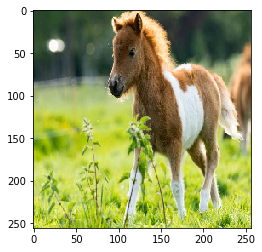

In [23]:
before=load_image('shetland-foal-pony.jpg')
plt.imshow(before.astype(int))

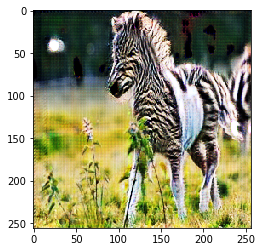

In [24]:
before=(before-127.5)/127.5
before=np.expand_dims(before,axis=0)
after=modelAtoB.predict(before)
plt.imshow((after[0]+1)/2)

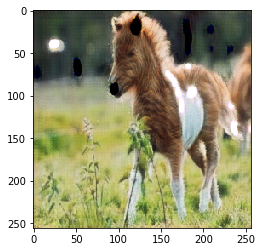

In [25]:
reconstruct=modelBtoA.predict(after)
plt.imshow((reconstruct[0]+1)/2)

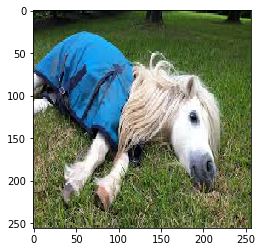

In [26]:
before=load_image('images.jpg')
plt.imshow(before.astype(int))

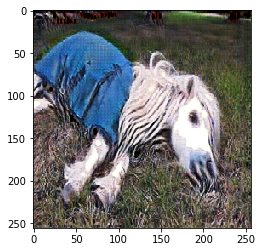

In [27]:
before=(before-127.5)/127.5
before=np.expand_dims(before,axis=0)
after=modelAtoB.predict(before)
plt.imshow((after[0]+1)/2)

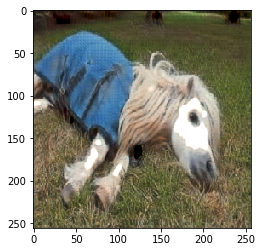

In [28]:
reconstruct=modelBtoA.predict(after)
plt.imshow((reconstruct[0]+1)/2)